In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from Utils.preprocessing import EcgDataset, ToTensor


transform = transforms.Compose([
    ToTensor(),
    transforms.Resize([64, 64])
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

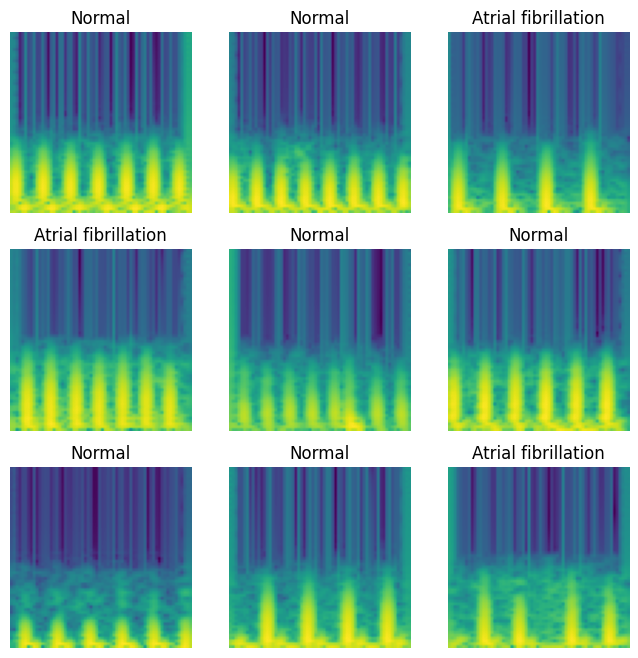

In [2]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [3]:
from torchsummary import summary
from Network.afib_detector_v2_1 import AfibDetector

net = AfibDetector()

if torch.cuda.is_available():
    net.cuda()

summary(net, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 54]           1,088
       BatchNorm2d-2           [-1, 32, 62, 54]              64
              ReLU-3           [-1, 32, 62, 54]               0
         MaxPool2d-4           [-1, 32, 31, 18]               0
            Conv2d-5            [-1, 64, 30, 8]          45,120
       BatchNorm2d-6            [-1, 64, 30, 8]             128
              ReLU-7            [-1, 64, 30, 8]               0
         MaxPool2d-8            [-1, 64, 15, 2]               0
            Linear-9                  [-1, 256]         491,776
             ReLU-10                  [-1, 256]               0
          Dropout-11                  [-1, 256]               0
           Linear-12                    [-1, 2]             514
       LogSoftmax-13                    [-1, 2]               0
Total params: 538,690
Trainable params:

In [4]:
import torch.nn as nn
from torch import optim
from Utils.model_trainer import ModelTrainer
import os

MODEL_PATH = "./Models/afib_detector_v2_0_1/afib_detector_v2_0_5"
if not os.path.exists(os.path.dirname(MODEL_PATH)):
        os.makedirs(os.path.dirname(MODEL_PATH))

learning_rate = 0.00005

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

epochs = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

net.to(device)

modelTrainer = ModelTrainer(MODEL_PATH)

modelTrainer.train_model(
    net,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    epochs
)

Device: cuda:0
EPOCH 1:
	batch 1550 loss: 0.4116619885544623
	batch 3100 loss: 0.26802527021496525
	batch 4650 loss: 0.2107396884118357
	batch 6200 loss: 0.1823147337883711
	batch 7750 loss: 0.1638283923436557
LOSS train 0.1638283923436557 valid 0.14247334521799865 ACCURACY 0.9464297890663147
EPOCH 2:
	batch 1550 loss: 0.14870520848901042
	batch 3100 loss: 0.1435529226268972
	batch 4650 loss: 0.13018675905081534
	batch 6200 loss: 0.12635745445326452
	batch 7750 loss: 0.12180359318251571
LOSS train 0.12180359318251571 valid 0.12233895088088242 ACCURACY 0.9529033899307251
EPOCH 3:
	batch 1550 loss: 0.11513394294727233
	batch 3100 loss: 0.1105682559876192
	batch 4650 loss: 0.10822313634318209
	batch 6200 loss: 0.10339748898881577
	batch 7750 loss: 0.10223214082209574
LOSS train 0.10223214082209574 valid 0.1088451296374463 ACCURACY 0.9590383768081665
EPOCH 4:
	batch 1550 loss: 0.09623086175971454
	batch 3100 loss: 0.09266305069499199
	batch 4650 loss: 0.09140441183962168
	batch 6200 loss: 

KeyboardInterrupt: 